In [2]:
from google.cloud import bigquery
import uuid
from pandas.io.gbq import read_gbq
import pandas as pd
import numpy as np
from fbprophet import Prophet
%matplotlib inline

bigquery_client = bigquery.Client()

In [4]:
# query day by day
query = '''#standardSQL
SELECT
  date(created_date), complaint_type, count(unique_key)
FROM
  `bigquery-public-data.new_york.311_service_requests`
GROUP BY
date(created_date),complaint_type
'''
project_id= ... ## ADD YOURS
general_volume_types = pd.read_gbq(query=query, project_id=project_id, dialect='standard')

Traceback (most recent call last):
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/discovery/v1/apis/bigquery/v2/rest
INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/jobs?alt=json
Traceback (most recent call last):
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/Users/mfumagalli/anaconda/lib/python2.7/site-packages/googleapiclient/d

Requesting query... 

INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/jobs?alt=json


ok.
Job ID: job_P8tIwRLTeDLDYp1k_EL8bd_tRNn0
Query running...


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/queries/job_P8tIwRLTeDLDYp1k_EL8bd_tRNn0?alt=json


Query done.
Cache hit.

Retrieving results...


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/queries/job_P8tIwRLTeDLDYp1k_EL8bd_tRNn0?pageToken=BGV2ZZNPLYAQAAASA4EAAEEAQCAAKGQIBCQI2BQQUCGQMIFQVYKQ%3D%3D%3D%3D&alt=json


  Got page: 2; 55.0% done. Elapsed 12.34 s.


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/queries/job_P8tIwRLTeDLDYp1k_EL8bd_tRNn0?pageToken=BGV2ZZNPLYAQAAASA4EAAEEAQCAAKGQIBDAJUDAQUCGQMIFQVYKQ%3D%3D%3D%3D&alt=json


  Got page: 3; 83.0% done. Elapsed 18.01 s.


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/resonant-hawk-125714/queries/job_P8tIwRLTeDLDYp1k_EL8bd_tRNn0?pageToken=BGV2ZZNPLYAQAAASA4EAAEEAQCAAKGQIBDQKOEQQUCGQMIFQVYKQ%3D%3D%3D%3D&alt=json


  Got page: 4; 100.0% done. Elapsed 21.84 s.
Got 362184 rows.

Total time taken 25.23 s.
Finished at 2017-09-23 14:00:42.


# MOST COMMON TYPES

In [42]:
a=pd.DataFrame(general_volume_types.groupby('complaint_type').f1_.sum())
a.sort_values('f1_', ascending=False)[0:26]

,f1_
complaint_type,
Noise - Residential,1298415
HEATING,887869
Street Condition,756077
Street Light Condition,747817
HEAT/HOT WATER,703178
PLUMBING,605708
Blocked Driveway,604610
Illegal Parking,514218
GENERAL CONSTRUCTION,500863


# MODEL WITH NO COVARIATES


In [97]:
type_of_compaint = 'Rodent'

general_volume=general_volume_types[general_volume_types.complaint_type == type_of_compaint]

general_volume.head()
# general_volume.to_pickle('volume_of_calls.csv')
general_volume.columns=['ds','complaint_type','y']

In [99]:
m = Prophet()
m.fit(general_volume)

future = m.make_future_dataframe(periods=0)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2816,2017-09-18,126.293795,104.418037,147.343293
2817,2017-09-19,124.418279,100.738172,146.042755
2818,2017-09-20,122.972473,100.353377,143.555718
2819,2017-09-21,118.431756,96.022931,141.573384
2820,2017-09-22,109.183970,85.842102,130.228609


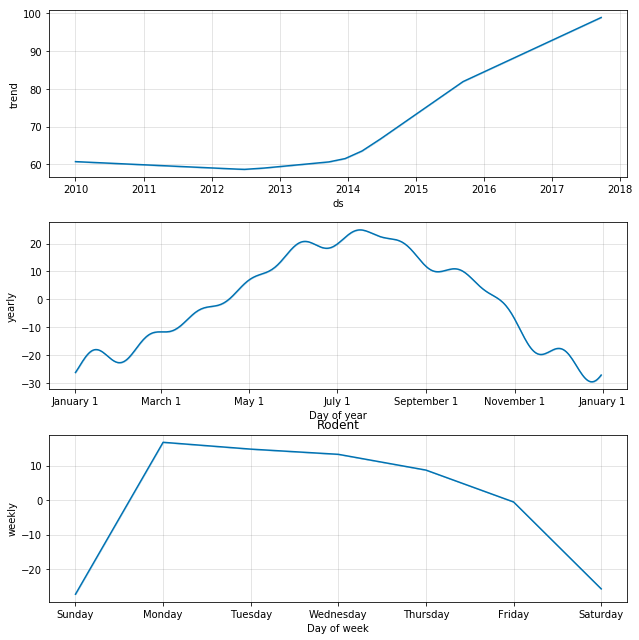

In [100]:

m.plot_components(forecast);
plt.title(type_of_compaint)
plt.savefig(type_of_compaint+'_season'+'.png')

In [101]:
general_volume['ds']=general_volume.ds.astype('datetime64[ns]')
joined_df = general_volume.merge(forecast, left_on='ds', right_on='ds')

/Users/mfumagalli/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


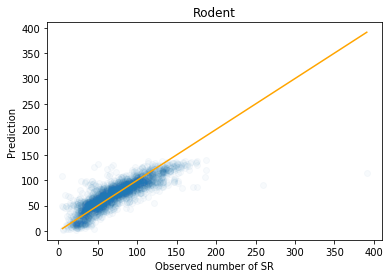

In [102]:
from matplotlib import pyplot as plt
%matplotlib inline 
from sklearn.metrics import r2_score

plt.scatter(joined_df.y, joined_df.yhat, alpha=0.03)
r2= r2_score(joined_df.y, joined_df.yhat)
plt.xlabel('Observed number of SR')
plt.ylabel('Prediction')
plt.title(type_of_compaint)

plt.plot([joined_df.y.min(),joined_df.y.max()],[joined_df.y.min(),joined_df.y.max()], color='orange')
plt.savefig(type_of_compaint+'_season_prediction'+'.png')

# ADD WEATHER BASED DATA

In [103]:
# add weather 
df=pd.DataFrame()
for year in range(2010,2018):
    df_year=pd.read_csv('../311NYC/WeatherUnderground/output/'+str(year)+'.csv')
    df=df.append(df_year)
df['Date']=df['Date'].astype('datetime64[ns]')


In [104]:
volume_weather=general_volume.merge(df, left_on='ds' , right_on='Date')
volume_weather.head()

# i need to kill 2 days with no data
volume_weather=volume_weather[~volume_weather.T_avg.isnull()]

/Users/mfumagalli/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean()
  app.launch_new_instance()
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


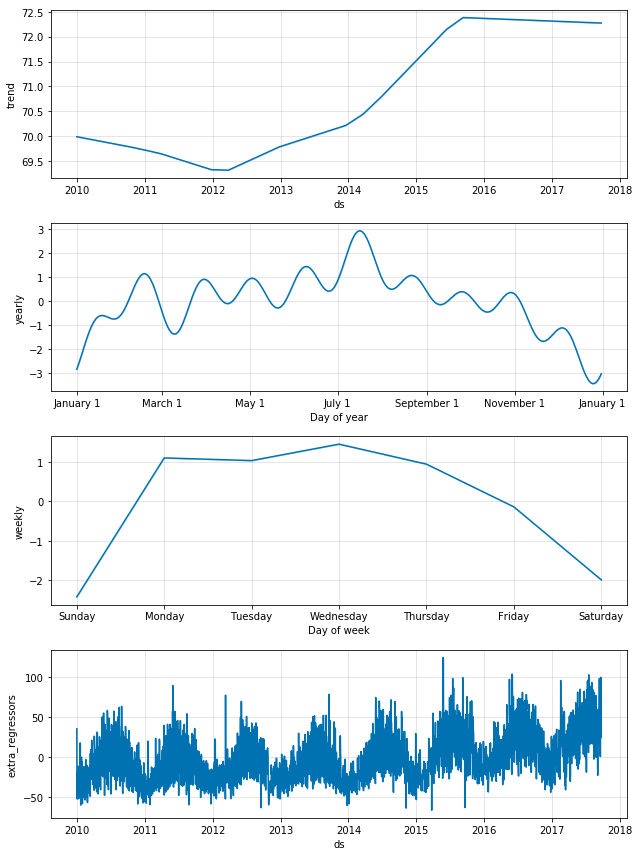

In [105]:
m = Prophet()


def snow(x):
    if x.event =='Snow':
        return x.R_sum
    else:
        return 0

volume_weather['snow'] = volume_weather.apply(lambda x: snow(x), axis=1)


volume_weather['y_minus_1']=volume_weather.y.shift(1)
volume_weather['y_minus_2']=volume_weather.y.shift(2)

volume_weather['mean_previous_week']=pd.rolling_mean(volume_weather.y, window=6)
volume_weather=volume_weather.fillna(0) # for the first day when we have no info

regressors = ['T_avg','R_sum', 'W_high', 'H_high','T_high','T_low','DP_high', 'snow','y_minus_2','y_minus_1','mean_previous_week']
for r in regressors:
    m.add_regressor(r)
m.fit(volume_weather)
#future_weather = m.make_future_dataframe(periods=0)
regressors.append('ds')
future_weather=volume_weather[regressors]

forecast = m.predict(future_weather)
m.plot_components(forecast);

joined_df = volume_weather.merge(forecast, left_on='ds', right_on='ds')

plt.savefig(type_of_compaint+'_seasonweather'+'.png')

0.949264819774


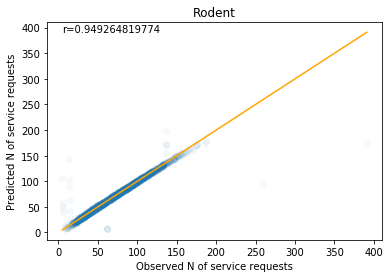

In [106]:
plt.scatter(joined_df.y, joined_df.yhat, alpha=0.03)
print r2_score(joined_df.y, joined_df.yhat)
plt.xlabel('Observed N of service requests')
plt.ylabel('Predicted N of service requests')

plt.text(joined_df.y.min(),joined_df.y.max(),"r="+str(r2_score(joined_df.y, joined_df.yhat)))
plt.title(type_of_compaint)
plt.plot([joined_df.y.min(),joined_df.y.max()],[joined_df.y.min(),joined_df.y.max()], color='orange')
plt.savefig(type_of_compaint+'_seasonweather_Prediction'+'.png')

# TRY A RANDOM FOREST

In [107]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
 
    
from sklearn.model_selection import train_test_split
features=regressors[:]
volume_weather['dayofweek']=volume_weather.Date.apply(lambda x: x.dayofweek)
volume_weather['day']=volume_weather.Date.apply(lambda x: x.day)
volume_weather['month']=volume_weather.Date.apply(lambda x: x.month)
features.remove('ds')
features.append('dayofweek')
features.append('day')
features.append('month')

X_train, X_test, y_train, y_test = train_test_split(volume_weather[features], volume_weather['y'], test_size=0.33, random_state=422)
    
num_features = volume_weather[features].shape[1]
# Use at most half of the features
max_features= 20
max_features = max(1, min(int(volume_weather[regressors].shape[1] / 2), max_features))
estimator = ExtraTreesRegressor(max_features=max_features,n_estimators=1000)

estimator.fit(X_train, y_train)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [108]:
Yhat_test=estimator.predict(X_test)

0.954912438022


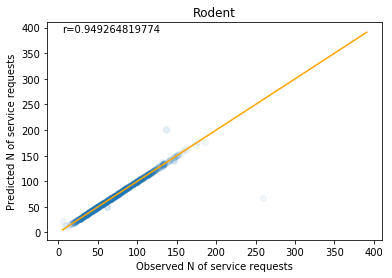

In [109]:
plt.scatter(y_test,Yhat_test, alpha=0.06)
print r2_score(y_test,Yhat_test)
plt.xlabel('N of calls')
plt.xlabel('Observed N of service requests')
plt.ylabel('Predicted N of service requests')

plt.text(joined_df.y.min(),joined_df.y.max(),"r="+str(r2_score(joined_df.y, joined_df.yhat)))
plt.title(type_of_compaint)
plt.plot([joined_df.y.min(),joined_df.y.max()],[joined_df.y.min(),joined_df.y.max()], color='orange')
plt.savefig(type_of_compaint+'_ForestModel_Prediction'+'.png')

In [110]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator, volume_weather[features], volume_weather['y'])
scores

array([ 0.02928966,  0.65043356,  0.58049904])

In [111]:
verif=X_test.copy()
verif['yhat']=Yhat_test
verif['y']=y_test
